# Arboles de decision
Son ua tecnica de machine learning que se utiliza mucho para problemas de clasificacion, pues sus resultados son muy faciles de explicar


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
url = 'http://dmontero.org/mineria/datasets/diabetes.csv'
df = pd.read_csv(url)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: xlabel='Glucose', ylabel='BMI'>

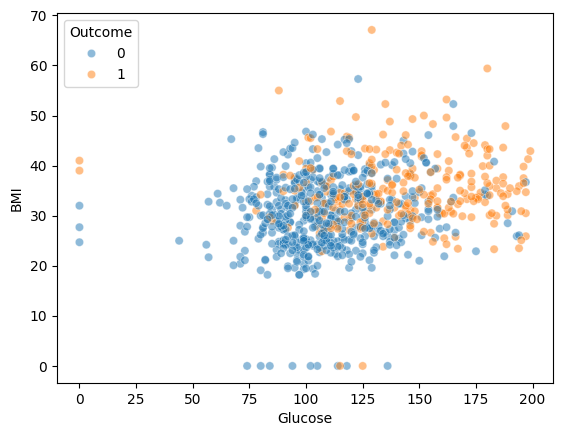

In [25]:
# Nos quedaremos con solo 2 columnas: BMI y Glucose
sns.scatterplot(
    data = df,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)

Mirando en detalle, intutivamente que para dividir a las personas que tienen diabetes con las que no debemos tomar el valor de glucosa = 125. ¿Como formalizamos esa intuicion?, las primeras ideas de esto aparecen en 1948 cuando Claude Shannon difinio la funcion de entropia de la informacion:
$$
H(X) = -\sum_{x_i unicos} p(x_i) * log_2(p(x_i))
$$

Donde $x$ es el conjunto de datos etiquetados (Outcome en el ejemplo, $x_i$ son las clases de valores unicos de X (0, 1 en el ejemplo) y $p$ es la proporcion de valores de la clase respecto del total

In [46]:
# se define la funcion de entropia en codigo
def entropia(datos_etiqueta: pd.Series)-> float:
    clases = np.unique(datos_etiqueta)
    suma = 0
    for c in clases:
        p = sum(datos_etiqueta == c) / len(datos_etiqueta) # propmenor a 175orcion del totalclases
        factor = p * np.log2(p)
        suma = suma + factor
    return -1*suma

In [47]:
# calculo de entropia para outcome
entropia(df['Outcome'])


0.9331343166407831

In [28]:
# Se necesita que de alguna forma introducir el feature (Glucosa) en el problema, se hara cortando el espacio por un valor de glucosa.
z = 175 # Valor de glucosa intuitivo
entropia(df['Outcome'][df['Glucose'] >= z]) # Entropia para los que tienen glucosa mayor o igual

0.6699960320994333

In [29]:
entropia(df['Outcome'][df['Glucose'] < z]) # Entropia para los que tienen glucosa menor

0.8941290186253704

La idea es considerar la entropia tanto a la derecha como a la izquierda, pero como para cada punto quedan conjuntos de diferente tamaño es necesario ponderar por el tamaño del conjunto

In [30]:
def entropia_ponderada(datos, feature, label, corte):
    indices = datos[feature] >= corte
    entropia_derecha = entropia(datos[label][indices])
    entropia_izquierda = entropia(datos[label][~indices])
    ponderacion_derecha = sum(indices) / len(datos)
    ponderacion_izquierda = 1 - ponderacion_derecha
    return entropia_derecha * ponderacion_derecha + entropia_izquierda * ponderacion_izquierda

In [31]:
entropia_ponderada(df, 'Glucose', 'Outcome', z)

0.8774941485316485

Se puede usar la entropia ponderada para encontrar el punto de corte optimo, pero formalmente se define una nueva funcion, llamada ganancia de informacion, que es la que finalmente se uiliza para encontrar el mejor punto de corte

In [32]:
def ganancia_info(datos,feature, label, corte):
    return entropia(datos[label]) - entropia_ponderada(datos, feature, label, corte)

In [33]:
ganancia_info(df, 'Glucose', 'Outcome', z)

0.055640168109134525

Entonces se busca el valor del feature que maximice la ganancia de la información. Para este caso, buscamos el valor de Glucosa que maximice la ganancia de información

In [38]:
# Se divide el valor de la glucosa en 100 artes y se ve cual es el maximo
listado_cortes_glucosa = np.linspace(df['Glucose'].min(),df['Glucose'].max(),100)
listado_gi_glucosa = []
for corte in listado_cortes_glucosa:
    listado_gi_glucosa.append(ganancia_info(df, 'Glucose', 'Outcome', corte))

<Axes: >

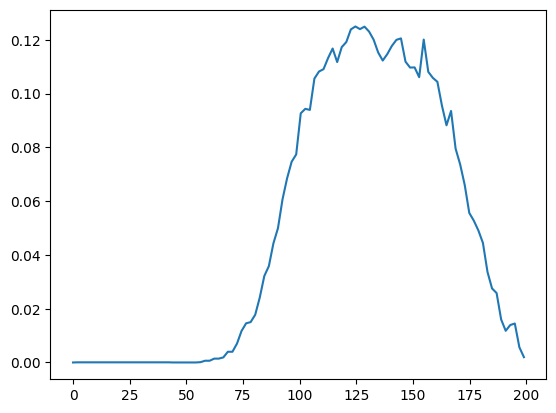

In [36]:
# graficamos
sns.lineplot(x=listado_cortes_glucosa, y=listado_gi_glucosa)

In [50]:
corte_optimo_glucosa = listado_cortes_glucosa[np.argmax(listado_gi_glucosa)]
corte_optimo_glucosa

124.62626262626262

In [51]:
# Se repite el mismo analisis con el BMI
listado_cortes_bmi = np.linspace(df['BMI'].min(),df['BMI'].max(),100)
listado_gi_bmi = []
for corte in listado_cortes_bmi:
    listado_gi_bmi.append(ganancia_info(df, 'BMI', 'Outcome', corte))


<Axes: >

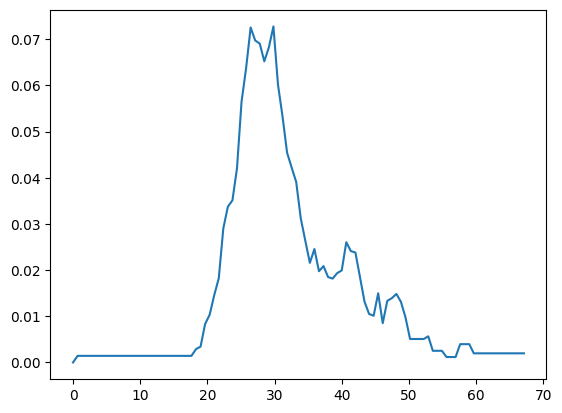

In [52]:
# Graficamos
sns.lineplot(x=listado_cortes_bmi, y=listado_gi_bmi)


In [53]:
corte_optimo_bmi = listado_cortes_bmi[np.argmax(listado_gi_bmi)]
corte_optimo_bmi

29.82222222222222